In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [10]:
def create_unet():
    """
    U-Net - just the core idea
    """
    # Input
    inputs = tf.keras.layers.Input((64, 64, 3))  # Small size for speed

    # Go down (encoder)
    x1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D(2)(x1)  # Make smaller

    x2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D(2)(x2)  # Make even smaller

    # Bottom
    bottom = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    # Go up (decoder)
    u1 = tf.keras.layers.UpSampling2D(2)(bottom)  # Make bigger
    u1 = tf.keras.layers.concatenate([u1, x2])    # Skip connection (key!)
    x3 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = tf.keras.layers.UpSampling2D(2)(x3)      # Make bigger again
    u2 = tf.keras.layers.concatenate([u2, x1])    # Skip connection (key!)
    x4 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    # Output (2 classes: background, circle)
    outputs = tf.keras.layers.Conv2D(2, 1, activation='softmax')(x4)

    model = tf.keras.Model(inputs, outputs)
    return model

In [11]:
def create_simple_data(num_samples=100):
    """
    Create very simple dataset - just circles vs background
    """
    images = []
    masks = []

    print(f"Creating {num_samples} simple images with circles...")

    for i in range(num_samples):
        # Create blank 64x64 image
        img = np.zeros((64, 64, 3), dtype=np.uint8)
        mask = np.zeros((64, 64), dtype=np.uint8)

        # Add random circle
        center = (np.random.randint(15, 49), np.random.randint(15, 49))
        radius = np.random.randint(8, 15)
        color = np.random.randint(100, 255, 3).tolist()

        # Draw circle on image and mask
        cv2.circle(img, center, radius, color, -1)
        cv2.circle(mask, center, radius, 1, -1)  # Class 1 for circle

        images.append(img)
        masks.append(mask)

    # Convert and normalize
    images = np.array(images, dtype=np.float32) / 255.0
    masks = np.array(masks, dtype=np.int32)

    print("Simple dataset created!")
    return images, masks

In [12]:
def show_examples(images, masks, predictions=None):
    """
    Show examples in a simple way
    """
    fig, axes = plt.subplots(2 if predictions is None else 3, 3, figsize=(9, 6))

    for i in range(3):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        # Mask (red = circle, black = background)
        mask_colored = np.zeros((*masks[i].shape, 3))
        mask_colored[masks[i] == 1] = [1, 0, 0]  # Red for circle
        axes[1, i].imshow(mask_colored)
        axes[1, i].set_title('True Mask')
        axes[1, i].axis('off')

        # Predictions (if provided)
        if predictions is not None:
            pred_colored = np.zeros((*predictions[i].shape, 3))
            pred_colored[predictions[i] == 1] = [1, 0, 0]  # Red for circle
            axes[2, i].imshow(pred_colored)
            axes[2, i].set_title('Predicted')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def run_exercise():
    """
    Complete simple exercise in one function
    """
    print("=" * 40)
    print("VERY SIMPLE U-NET EXERCISE")
    print("=" * 40)
    print("Goal: Learn to detect circles!")

    # 1. Create data
    print("\n1. Creating simple data...")
    images, masks = create_simple_data(num_samples=100)  # Small dataset
    print(f"   Images: {images.shape}")
    print(f"   Classes: 0=background, 1=circle")

    # 2. Show examples
    print("\n2. Showing examples...")
    show_examples(images[:3], masks[:3])

    # 3. Split data
    print("\n3. Splitting data...")
    split = 80
    train_images, test_images = images[:split], images[split:]
    train_masks, test_masks = masks[:split], masks[split:]
    print(f"   Train: {len(train_images)}, Test: {len(test_images)}")

    # 4. Create model
    print("\n4. Creating simple U-Net...")
    model = create_unet()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"   Model has {model.count_params():,} parameters")

    # 5. Train (very quick)
    print("\n5. Training model...")
    print("   This will be quick!")

    history = model.fit(
        train_images, train_masks,
        batch_size=16,
        epochs=5,  # Very few epochs
        validation_data=(test_images, test_masks),
        verbose=1
    )

    # 6. Check results
    print("\n6. Testing model...")
    test_loss, test_accuracy = model.evaluate(test_images, test_masks, verbose=0)
    print(f"   Test accuracy: {test_accuracy:.2f}")

    # 7. Show predictions
    print("\n7. Showing predictions...")
    predictions = model.predict(test_images[:3])
    pred_masks = np.argmax(predictions, axis=-1)

    show_examples(test_images[:3], test_masks[:3], pred_masks)

    # 8. Simple training plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='Train')
    plt.plot(history.history['val_loss'], 'r-', label='Test')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Train')
    plt.plot(history.history['val_accuracy'], 'r-', label='Test')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

VERY SIMPLE U-NET EXERCISE
Goal: Learn to detect circles!

1. Creating simple data...
Creating 100 simple images with circles...
Simple dataset created!
   Images: (100, 64, 64, 3)
   Classes: 0=background, 1=circle

2. Showing examples...


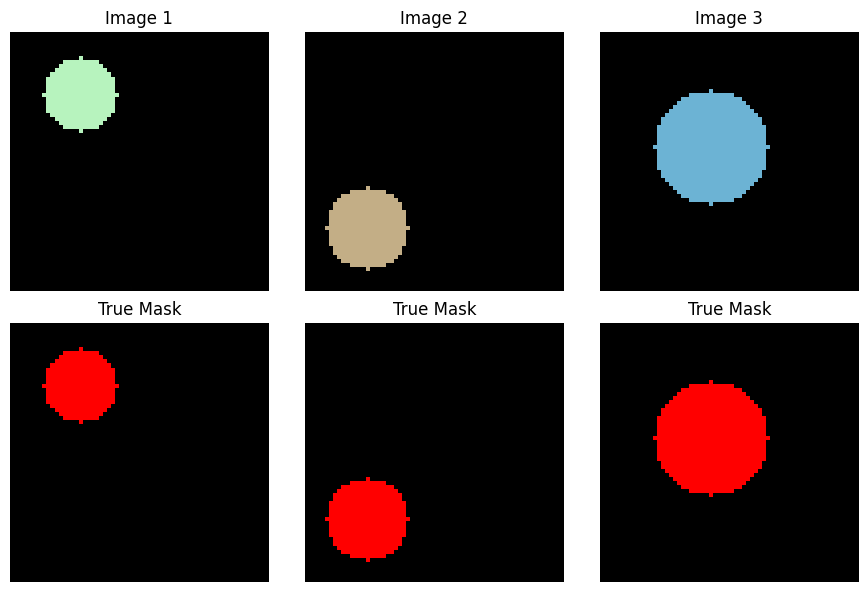


3. Splitting data...
   Train: 80, Test: 20

4. Creating simple U-Net...
   Model has 58,226 parameters

5. Training model...
   This will be quick!
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.8998 - loss: 0.6814 - val_accuracy: 0.9854 - val_loss: 0.5948
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.9846 - loss: 0.5426 - val_accuracy: 0.9913 - val_loss: 0.3180
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.9929 - loss: 0.2342 - val_accuracy: 0.9963 - val_loss: 0.0388
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.9963 - loss: 0.0266 - val_accuracy: 0.9959 - val_loss: 0.0118
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.9962 - loss: 0.0100 - val_accuracy: 0.9961 - val_loss: 0.0114

6. Testing model...
   Test accuracy: 1.00

7. Showing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


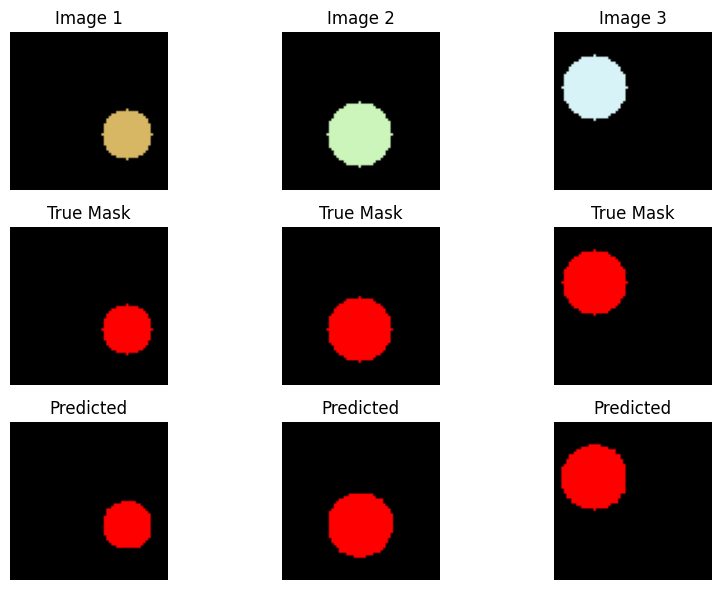

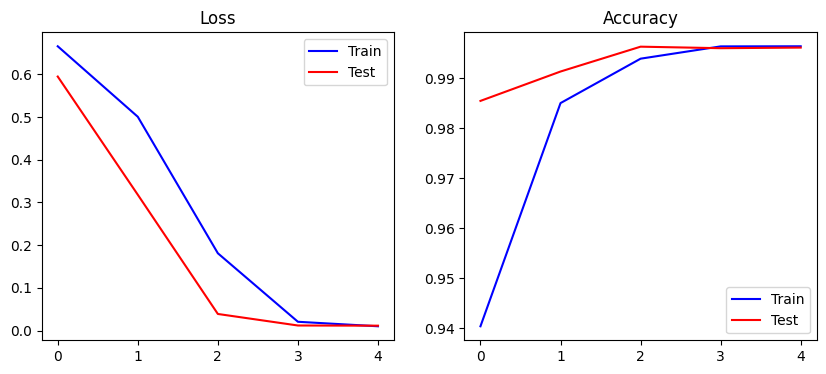

In [14]:
run_exercise()